In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway
from statannotations.Annotator import Annotator
from itertools import combinations
import sys
import importlib
sys.path.append('../scripts') 
from functions import *
from config import nutrient_info, conversion_factors

In [2]:
%load_ext autoreload
%autoreload 2

# QI, DI and NB incides calculation

In [3]:
df_food = pd.read_csv("../data/df_food_filtered_with_food_group.csv",index_col=0)
with open("../data/df_food_openfoodfacts_merged.pkl", "rb") as f:
    df_food_openfoodfacts = pickle.load(f, encoding="latin1")

C:\Users\Sophie\AppData\Local\Temp\ipykernel_14564\2857174756.py:1: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food = pd.read_csv("../data/df_food_filtered_with_food_group.csv",index_col=0)


In [4]:
df_food = df_food[df_food["eaten_quantity_in_gram"] > 10]
df_food = df_food[df_food["energy_kcal_eaten"] > 10]

In [5]:
# assign _eaten to water to add to the nutrient list 
df_food = df_food.assign(
    water_eaten = df_food['water']
)

In [6]:
qualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'qualifying'}
disqualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'disqualifying'}

In [7]:

df_food_ratio = calculate_ratios(df_food.fillna(0), list(nutrient_info.keys()))
df_food_scaled = scale(df_food_ratio.fillna(0), list(nutrient_info.keys()), scaling_factor=2000)

In [8]:
df_food_ratio['QI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=qualifying_nutrients)
df_food_scaled['QI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=qualifying_nutrients)

In [9]:
df_food_ratio['DI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=disqualifying_nutrients)
df_food_scaled['DI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=disqualifying_nutrients)

In [10]:
df_food_ratio['NB'] = df_food_scaled.apply(compute_nb, axis=1, nutrient_cols=qualifying_nutrients)
df_food_scaled['NB'] = df_food_scaled.apply(compute_nb, axis=1, nutrient_cols=qualifying_nutrients)

In [11]:
df_food_ratio.to_csv('../data/df_food_ratio.csv', index=False)
df_food_scaled.to_csv('../data/df_food_scaled.csv', index=False)


In [12]:
df_food_scaled[['QI', 'DI','NB', 'combined_name', 'food_group']].groupby('food_group').median(numeric_only=True).sort_values('QI')

,QI,DI,NB
food_group,,,
sweetened_beverages,0.055006,0.664300,5.000000
alcoholic_beverages,0.067630,0.007668,6.723460
soups_sauces_condiments,0.098568,1.068889,8.033738
salty_snacks,0.126519,0.526942,10.000000
cooked_grains_pasta,0.144388,0.517566,10.240210
sweets_desserts,0.169476,0.863140,14.164075
butter_margarine_spreads,0.217511,1.837749,11.120121
vegetable_oils,0.231921,0.694173,5.250201
vegetable_fruit_juices,0.244367,0.626646,12.787068


In [13]:
df_food_scaled.sort_values('QI', ascending=False)[['QI', 'combined_name']].drop_duplicates('combined_name').head(30)

,QI,combined_name
474625,253.590212,MClassic - Saladbowl Chicken
495568,162.640695,Andros - Apfel-Pfirsich und Aprikosenmus
479112,162.534636,Andros - Apfel
479583,149.755449,ANDROS FRUIT ME UP! Apple Mango
495564,146.937744,Andros - Apfel-Banane-Erdbeerenmus
473688,146.893513,Alnatura Apple purée with apricot
475711,146.693221,Betty Bossi - Chicken Caesar Salad (& caesar d...
427219,142.821438,"Chicken caesar salad (green salad, cheese, cro..."
472094,142.809106,Ceasar salad
494913,139.035053,Fruchtmus Apfel & Ananas


In [14]:
for i in df_food_scaled[df_food_scaled['food_group'] == 'milk'].drop_duplicates('combined_name')['combined_name'] :
    print(i)

Milk, ewe's, raw
Milk, goat
Skimmed milk
Milk
Lactose-free milk
Milk drink
Whole milk / unskimmed milk
Buttermilk
Coconut milk
Rice milk
Soya drink (soy milk)
Rice, milk
Alnatura Maudel Drink ungesüsst
Isola Bio Rice
Oat milk
Emmi ENERGY MILK NEW 26g HIGH PROTEIN Vanilla
Vanillemilch aus Milch
Naturaplan : Drink : Teilentrahmte Milch
Coop Mountain milk from the Friborg Pre-Alps
Almond drink (almond milk)
Emmi good day Milky drink
Cremo - Milch UHT
Milchmischerzeugnis aus Vollmilch
Cailler Milch
Coop naturaplan Reisgetränk Haselnuss
Coop : Freeform : Milch : Lactosefrei
Sojasun Schokolade
Coop - Drink Semi-skimmed milk, 1.5% milkfat
Sojasun Boisson de soja Nature
Coop : Karma : Bio Oat Drink Vegan
Alnatura - Coco drink natur
Sojasun Natural
Kondensmilch, gezuckert
VALFLORA : Homogenisiert Halbentrahmte Milch
freefrom Milch
ALNATURA - coconut nature vegan
Partially skimmed milk 2.5% fat
Migros Bio UHT Milch
Sojasun - Soja & Amande
MIGROS : AHA : Milch halbentrahmt laktosefrei
Karma Bio M

In [15]:
name = 'Carrot (old variety, white)'



In [16]:
df_food[df_food['combined_name'] == name].describe().T

,count,mean,std,min,25%,50%,75%,max
food_id,7.0,1079.000000,0.000000,1079.00000,1079.00000,1079.00000,1079.00000,1079.00000
dish_id,7.0,128770.857143,151866.858799,6763.00000,10490.50000,89162.00000,219170.00000,346150.00000
eaten_quantity,7.0,77.142857,29.840848,30.00000,70.00000,80.00000,80.00000,130.00000
eaten_at_utc_offset,7.0,60.000000,0.000000,60.00000,60.00000,60.00000,60.00000,60.00000
media_count,7.0,1.000000,0.000000,1.00000,1.00000,1.00000,1.00000,1.00000
...,...,...,...,...,...,...,...,...
vitamin_c_eaten,7.0,0.002546,0.000985,0.00099,0.00231,0.00264,0.00264,0.00429
vitamin_d_eaten,7.0,0.000000,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000
vitamin_e_activity_eaten,7.0,0.432000,0.167109,0.16800,0.39200,0.44800,0.44800,0.72800
zinc_eaten,7.0,0.000077,0.000030,0.00003,0.00007,0.00008,0.00008,0.00013


## Milk subgroups

In [17]:
for i in df_food[df_food['food_group'] == 'milk'].drop_duplicates('combined_name')['combined_name']:
    print(i)

Milk, ewe's, raw
Milk, goat
Skimmed milk
Milk
Lactose-free milk
Milk drink
Whole milk / unskimmed milk
Buttermilk
Coconut milk
Rice milk
Soya drink (soy milk)
Rice, milk
Alnatura Maudel Drink ungesüsst
Isola Bio Rice
Oat milk
Emmi ENERGY MILK NEW 26g HIGH PROTEIN Vanilla
Vanillemilch aus Milch
Naturaplan : Drink : Teilentrahmte Milch
Coop Mountain milk from the Friborg Pre-Alps
Almond drink (almond milk)
Emmi good day Milky drink
Cremo - Milch UHT
Milchmischerzeugnis aus Vollmilch
Cailler Milch
Coop naturaplan Reisgetränk Haselnuss
Coop : Freeform : Milch : Lactosefrei
Sojasun Schokolade
Coop - Drink Semi-skimmed milk, 1.5% milkfat
Sojasun Boisson de soja Nature
Coop : Karma : Bio Oat Drink Vegan
Alnatura - Coco drink natur
Sojasun Natural
Kondensmilch, gezuckert
VALFLORA : Homogenisiert Halbentrahmte Milch
freefrom Milch
ALNATURA - coconut nature vegan
Partially skimmed milk 2.5% fat
Migros Bio UHT Milch
Sojasun - Soja & Amande
MIGROS : AHA : Milch halbentrahmt laktosefrei
Karma Bio M

In [18]:
milk_catergories = {
    'vegan_milk' : [
        'soy', 'soja',
        'rice', 'riz', 'reis',
        'almond', 'amande', 'mandel',
        'coconut'

    ]
}

In [19]:
def create_milk_subgroup(name):
    name_lower = name.lower()

    for subgroup, keywords in milk_catergories.items():
        if any(keyword in name_lower for keyword in keywords):
            return subgroup
    return 'dairy_milk'

In [20]:
df_milk = df_food_scaled[df_food_scaled['food_group'] == 'milk'].copy()
df_milk['milk_subgroup'] = df_milk['combined_name'].apply(create_milk_subgroup)
df_milk
print(df_milk['milk_subgroup'].value_counts())

milk_subgroup
dairy_milk    5224
vegan_milk    1779
Name: count, dtype: int64


In [21]:
df_milk.groupby('milk_subgroup')[['QI', 'DI', 'NB']].mean()

,QI,DI,NB
milk_subgroup,,,
dairy_milk,7.633993,1.140912,54.212398
vegan_milk,0.466883,0.875941,18.609914


## Vegetables subgroup

In [22]:
vegetable_categories = {
    'root_vegetables': [
        'carrot', 'carotte', 'karotte', 'möhre',
        'beetroot', 'betterave', 'rote bete', 'rübe',
        'turnip', 'navet', 'steckrübe',
        'parsnip', 'panais', 'pastinake',
        'celeriac', 'céleri-rave', 'knollensellerie',
        #'onion', 'oignon', 'zwiebel',
        'radish', 'radis', 'radieschen',
        #'fennel', 'fenouil', 'fenchel',
        'potato', 'pomme de terre', 'kartoffel'
    ],
    'leafy_vegetables': [
        'spinach', 'épinard', 'spinat',
        'beet', 'blette', 'mangold',
        'chicory', 'chicorée',
        'endive', 'endivie',
        'lettuce', 'laitue', 'kopfsalat', 'salat',
        'kale', 'chou frisé', 'grünkohl',
        'cabbage', 'chou', 'kohl',
        'rocket', 'roquette', 'rucola',
        'arugula', 
        'mustard', 'moutarde', 'senf'
    ],
    'fruity_vegetables': [
        'avocado', 'avocat',
        #'asparagus', 'asperge', 'spargel',
        'cucumber', 'cucumbers', 'concombre',
        'eggplant', 'aubergine',
        'olive',  
        'pea', 'peas', 'pois', 'erbse', 'erbsen',
        #'maïs', 'mais',
        'tomato', 'tomate',
        'pepper', 'poivron', 'paprika',
        'squash', 'courge', 'kürbis',
        'zucchini', 'courgette'
    ],
    'pickled_vegetables' : [
        'cornichon', 'chirat',
        'pickled', 'mariné', 'eingelegt'

    ]
}


In [23]:
def create_vegetables_subgroup(name):
    name_lower = name.lower()
    for subgroup, keywords in vegetable_categories.items():
        if any(keyword in name_lower for keyword in keywords):
            return subgroup
    return 'other_vegetables'

In [24]:
df_vegetables = df_food_scaled[df_food_scaled['food_group']=='vegetables'].copy()
df_vegetables['vegetable_subgroup'] = df_vegetables['combined_name'].apply(create_vegetables_subgroup)
df_vegetables
print(df_vegetables['vegetable_subgroup'].value_counts())

vegetable_subgroup
other_vegetables      13240
fruity_vegetables      8025
root_vegetables        5382
leafy_vegetables       2395
pickled_vegetables       47
Name: count, dtype: int64


In [25]:
for i in df_vegetables.columns :
    print(i)

food_id
barcode
dish_id
eaten_quantity
eaten_unit
subject_key
eaten_at
eaten_at_utc_offset
media_count
food_group_cname
type
display_name_en
display_name_fr
display_name_de
fallback_food_id
standard_portion_quantity
standard_portion_unit
specific_gravity
alcohol
all_trans_retinol_equivalents_activity
beta_carotene
beta_carotene_activity
calcium
carbohydrates
chloride
cholesterol
energy_kcal
energy_kj
fat
fatty_acids_monounsaturated
fatty_acids_polyunsaturated
fatty_acids_saturated
fiber
folate
iodide
iron
magnesium
niacin
pantothenic_acid
phosphorus
potassium
protein
salt
sodium
starch
sugar
vitamin_a_activity
vitamin_b1
vitamin_b12
vitamin_b2
vitamin_b6
vitamin_c
vitamin_d
vitamin_e_activity
water
zinc
eaten_quantity_in_gram
energy_kcal_eaten
energy_kj_eaten
carb_eaten
fat_eaten
protein_eaten
fiber_eaten
alcohol_eaten
local_eaten_at
eaten_date
combined_name
all_trans_retinol_equivalents_activity_eaten
beta_carotene_eaten
calcium_eaten
cholesterol_eaten
fatty_acids_monounsaturated_eate

In [26]:
df_vegetables[['QI', 'DI', 'NB', 'vegetable_subgroup']].groupby('vegetable_subgroup').median(numeric_only=True).sort_values('QI')

,QI,DI,NB
vegetable_subgroup,,,
pickled_vegetables,1.297822,0.140400,71.444663
root_vegetables,2.124007,0.731399,80.790109
other_vegetables,3.940625,0.361079,84.166667
fruity_vegetables,4.208584,0.477981,82.812500
leafy_vegetables,5.225333,0.415157,85.000000


In [27]:
df_vegetables.describe()

,food_id,dish_id,eaten_quantity,eaten_at_utc_offset,media_count,fallback_food_id,standard_portion_quantity,specific_gravity,alcohol,all_trans_retinol_equivalents_activity,...,water_eaten_ratio_scaled,fat_eaten_ratio_scaled,fatty_acids_saturated_eaten_ratio_scaled,cholesterol_eaten_ratio_scaled,sugar_eaten_ratio_scaled,sodium_eaten_ratio_scaled,salt_eaten_ratio_scaled,QI,DI,NB
count,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.0,29089.0,29089.000000,...,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000,29089.000000
mean,1213.001375,213547.296401,85.981715,94.359380,0.921001,13.435285,98.285331,0.0,0.0,0.278525,...,3.011271,0.374754,0.136779,0.122510,1.568734,1.185856,0.867372,3.692938,0.709334,69.384100
std,1872.814052,124170.928736,54.695868,35.117714,0.269742,136.773629,43.984169,0.0,0.0,3.750721,...,1.825591,0.418547,0.347678,1.176492,0.984869,3.426024,2.998975,2.614993,1.096116,26.657979
min,50.000000,682.000000,0.125000,-420.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016351,0.000000
25%,1026.000000,112447.000000,50.000000,60.000000,1.000000,0.000000,80.000000,0.0,0.0,0.000000,...,1.682670,0.202429,0.000000,0.000000,0.969231,0.063492,0.000000,1.589990,0.340171,74.928989
50%,1069.000000,204079.000000,80.000000,120.000000,1.000000,0.000000,120.000000,0.0,0.0,0.000000,...,2.789209,0.320513,0.000000,0.000000,1.600000,0.201613,0.000000,3.793393,0.444587,80.790109
75%,1085.000000,334513.000000,120.000000,120.000000,1.000000,0.000000,120.000000,0.0,0.0,0.000000,...,4.346979,0.388500,0.191087,0.000000,2.550000,0.614035,0.877193,5.507715,0.640051,85.000000
max,46296.000000,428224.000000,800.000000,240.000000,1.000000,5606.000000,306.000000,0.0,0.0,166.000000,...,7.012930,2.753258,5.244755,12.083333,3.789474,41.666667,47.619048,39.412849,14.479731,100.000000


In [28]:
df_vegetables[df_vegetables['combined_name'] == 'Epinards'][[i for i in df_vegetables.columns if '_eaten_scaled' in i]]

""
484235
484236


In [29]:
df_food_scaled[df_food_scaled['combined_name'] == 'Epinards']

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,water_eaten_ratio_scaled,fat_eaten_ratio_scaled,fatty_acids_saturated_eaten_ratio_scaled,cholesterol_eaten_ratio_scaled,sugar_eaten_ratio_scaled,sodium_eaten_ratio_scaled,salt_eaten_ratio_scaled,QI,DI,NB
484235,8436,7617027876896,80922,50.0,g,9hfx6d,2019-11-21 11:50:28,60,0,vegetables_fruits,...,5.906602,0.445931,0.395257,0.0,0.486957,2.355072,0.0,11.214939,0.613869,85.0
484236,8436,7617027876896,80671,50.0,g,9hfx6d,2019-11-20 11:07:35,60,0,vegetables_fruits,...,5.906602,0.445931,0.395257,0.0,0.486957,2.355072,0.0,11.214939,0.613869,85.0


## Yogurt and fresh dairy subgroup

In [30]:
for i in df_food[df_food['food_group'] == 'yogurt_fresh_dairy'].drop_duplicates('combined_name')['combined_name']:
    print(i)

Curds, natural, min. 40% fidm
Curds, natural, with at most 10% fidm
Curds, natural, min. 20% fidm
Yaourt, yahourt, yogourt ou yoghourt, vanilla
Yaourt, yahourt, yogourt ou yoghourt, mocca
Yaourt, yahourt, yogourt ou yoghourt, chocolate
Yaourt, yahourt, yogourt ou yoghourt, strawberry
Yaourt, yahourt, yogourt ou yoghourt, flavored, low fat, with sweetener
Yaourt, yahourt, yogourt ou yoghourt, Bifidus, plain
Yaourt, yahourt, yogourt ou yoghourt, natural, low fat
Actimel
Yoghurt drink
Kefir drink
Soya Yaourt, yahourt, yogourt ou yoghourt
Activia
Yaourt, yahourt, yogourt ou yoghourt, sweetened, (average)
Kefir yoghurt
Cottage cheese
Petit-Suisse
Curd
coop naturaplan Jogurt Vanilla
coop naturaplan Griechischer Jogurt Nature
coop naturaplan  Griechischer Jogurt Nature
Milco: Yogourt au lait de la Gruyère
Naturaplan : Jogurt : Haselnuss
Greek Yaourt, yahourt, yogourt ou yoghourt
Soja Line Soyog Mango
Coop Qualité & Prix Half fat cottage cheese
Coop Jogurt à la Grecque
Léger Joghurt Nature
Els

In [31]:
yogurt_categories = {
    'plain_yogurt' : [
        'natural', 'nature', 'plain',
        'curd', 'fromage blanc', 'hüttenkäse',
        'c,ottage', 'caillé' 
    ],
    'flavored_yogurt' : [
        'vanilla', 'vanille',
        'strawberry', 'fraise', 'erdbeere',
        'chocolate', 'schokolade', 
        'mocca',
        'blueberry', 'myrtille', 'blaubeere',
        'rasberry', 'framboise', 'himbeere',
        'mango', ',mangue'
    ],
    'greek_yogurt' : [
        'greek', 'grec', 'griechisch',
        'skyr',
        'icelandic', 'islandais', 'isländisch'
    ],
    'yogurt_drink' : [
        'drink', 'boisson', 'getränlk',
        'kefir'
    ]
}

In [32]:
def create_yogurt_subgroup(name):
    name_lower = name.lower()
    for subgroup, keywords in yogurt_categories.items():
        if any(keyword in name_lower for keyword in keywords):
            return subgroup
    return 'other_yogurt'

In [33]:
df_yogurt = df_food_scaled[df_food_scaled['food_group']=='yogurt_fresh_dairy'].copy()
df_yogurt['yogurt_subgroup'] = df_yogurt['combined_name'].apply(create_yogurt_subgroup)
df_yogurt
print(df_yogurt['yogurt_subgroup'].value_counts())

yogurt_subgroup
plain_yogurt       2348
other_yogurt       1988
greek_yogurt        547
flavored_yogurt     493
yogurt_drink        311
Name: count, dtype: int64


In [34]:
df_yogurt.groupby('yogurt_subgroup')[['QI', 'DI', 'NB']].median(numeric_only=True)

,QI,DI,NB
yogurt_subgroup,,,
flavored_yogurt,0.963391,0.877589,57.402318
greek_yogurt,75.249113,1.070352,64.975373
other_yogurt,1.012547,0.957764,55.884169
plain_yogurt,1.695686,1.208269,69.794592
yogurt_drink,0.199839,0.857001,7.592593


In [35]:
for i in  df_food_scaled.columns : 
    print(i)

food_id
barcode
dish_id
eaten_quantity
eaten_unit
subject_key
eaten_at
eaten_at_utc_offset
media_count
food_group_cname
type
display_name_en
display_name_fr
display_name_de
fallback_food_id
standard_portion_quantity
standard_portion_unit
specific_gravity
alcohol
all_trans_retinol_equivalents_activity
beta_carotene
beta_carotene_activity
calcium
carbohydrates
chloride
cholesterol
energy_kcal
energy_kj
fat
fatty_acids_monounsaturated
fatty_acids_polyunsaturated
fatty_acids_saturated
fiber
folate
iodide
iron
magnesium
niacin
pantothenic_acid
phosphorus
potassium
protein
salt
sodium
starch
sugar
vitamin_a_activity
vitamin_b1
vitamin_b12
vitamin_b2
vitamin_b6
vitamin_c
vitamin_d
vitamin_e_activity
water
zinc
eaten_quantity_in_gram
energy_kcal_eaten
energy_kj_eaten
carb_eaten
fat_eaten
protein_eaten
fiber_eaten
alcohol_eaten
local_eaten_at
eaten_date
combined_name
all_trans_retinol_equivalents_activity_eaten
beta_carotene_eaten
calcium_eaten
cholesterol_eaten
fatty_acids_monounsaturated_eate

In [36]:
df_food_scaled.groupby(['subject_key', 'meal', 'date',])["combined_name"].value_counts()

KeyError: 'meal'

# Statistical Tests

In [ ]:

def significance_test(data, group_col, value_col, alpha=0.05, non_parametric=False):
    groups = data[group_col].unique()
    if len(groups) == 2:
        group1 = data[data[group_col] == groups[0]][value_col]
        group2 = data[data[group_col] == groups[1]][value_col]
        if non_parametric:
            stat, p_val = mannwhitneyu(group1, group2)
            test_name = "Mann-Whitney U"
        else:
            stat, p_val = ttest_ind(group1, group2)
            test_name = "t-test"
        return p_val < alpha, p_val, test_name, stat
    elif len(groups) > 2:
        group_values = [data[data[group_col] == grp][value_col] for grp in groups]
        if non_parametric:
            stat, p_val = kruskal(*group_values)
            test_name = "Kruskal-Wallis"
        else:
            stat, p_val = f_oneway(*group_values)
            test_name = "ANOVA"
        return p_val < alpha, p_val, test_name, stat
    return False, 1.0, "No test", 0
def create_quartiles(df, column_name, ncut=4):
    """Add quartile categories (1-4) for a specified column in a DataFrame."""
    df_copy = df.copy()
    df_copy[column_name + "_quartile"] = pd.qcut(
        df_copy[column_name], q=ncut, labels=[f"Q{i}" for i in range(1, ncut + 1)]
    )
    return df_copy
def add_stat_annotation(ax, data, x, y, pairs, test="Mann-Whitney", text_format="star"):
    """Add statistical annotation bars to the plot."""
    annotator = Annotator(ax, pairs, data=data, x=x, y=y)
    annotator.configure(
        test=test,
        text_format=text_format,
        line_width=0.5,  # Thinner lines
        line_height=0.02,
    )  # Slightly shorter bars
    annotator.apply_and_annotate()
def test_quartile_differences(
    df,
    column_name,
    value_col,
    extremes=True,
    alpha=0.05,
    non_parametric=True,
    ax=None,
    palette="Spectral",
    make_quartile=True,
    verbose=False,
):
    """
    Test differences between quartiles of a specified column and create a boxplot with significance bars.
    """
    df = df.copy()
    if make_quartile:
        df = create_quartiles(df, column_name)
        quartile_col = column_name + "_quartile"
    else:
        quartile_col = column_name
    if extremes:
        df = df[df[quartile_col].isin(["Q1", "Q4"])]
        if isinstance(df[quartile_col].dtype, pd.CategoricalDtype):
            df[quartile_col] = df[quartile_col].cat.remove_unused_categories()
    # Create plot if ax not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    # Create boxplot
    sns.boxplot(
        data=df,
        x=quartile_col,
        y=value_col,
        ax=ax,
        linewidth=0.5,
        fliersize=1,
        width=0.5,
        palette=palette,
    )
    # Get unique groups and create pairs for comparison
    groups = sorted(df[quartile_col].dropna().astype(str).unique())
    if extremes:
        # If only comparing extremes, just compare Q1 and Q4
        pairs = [("Q1", "Q4")]
    else:
        # Create all possible pairs of quartiles
        pairs = list(combinations(groups, 2))
    # Determine statistical test
    test = "Mann-Whitney" if non_parametric else "t-test"
    # Add statistical annotation
    add_stat_annotation(ax, df, x=quartile_col, y=value_col, pairs=pairs, test=test)
    # Run the original significance test for console output
    is_sig, p_val, test_name, stat = significance_test(
        df, quartile_col, value_col, alpha=alpha, non_parametric=non_parametric
    )
    if verbose:
        if is_sig:
            print(
                f"{column_name} -> {value_col}\tSignificant differences exist.",
                f"{test_name} statistic: {stat:.3f} p-value: {p_val:.3f}",
            )
        else:
            print(f"{column_name} -> {value_col}\tNo significant differences.")
    # Add test statistics to plot
    ylims = ax.get_ylim()
    yrange = ylims[1] - ylims[0]
    text_y = ylims[1] + yrange * 0.05  # Position text above the plot
    # Format test information with abbreviated names
    test_abbrev = {
        "Kruskal-Wallis": "KW",
        "Mann-Whitney U": "MW",
        "ANOVA": "ANOVA",
        "t-test": "t-test",
    }
    abbreviated_name = test_abbrev.get(test_name, test_name)
    if test_name == "Kruskal-Wallis":
        test_info = f"${abbreviated_name}:$ $H={stat:.2f}$, $p={p_val:.3f}$"
    elif test_name == "Mann-Whitney U":
        test_info = f"${abbreviated_name}:$ $U={stat:.2f}$, $p={p_val:.3f}$"
    else:
        test_info = f"${abbreviated_name}:$ $t={stat:.2f}$, $p={p_val:.3f}$"
    # Add text with test information
    ax.text(
        0,
        text_y,
        test_info,
        horizontalalignment="left",
        verticalalignment="bottom",
        fontsize=8,
    )
    # Adjust plot limits to accommodate the text
    ax.set_ylim(ylims[0], ylims[1] + yrange * 0.15)
    return ax


In [ ]:
largest_meals.columns

Index(['subject_key', 'date', 'meal', 'total_energy', 'QI', 'DI', 'NB'], dtype='object')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:8.320e-03 U_stat=4.735e+05
lunch vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:1.552e-03 U_stat=5.494e+05
breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:6.572e-01 U_stat=5.148e+05


C:\Users\Sophie\AppData\Local\Temp\ipykernel_19428\363652421.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='meal', ylabel='NB'>

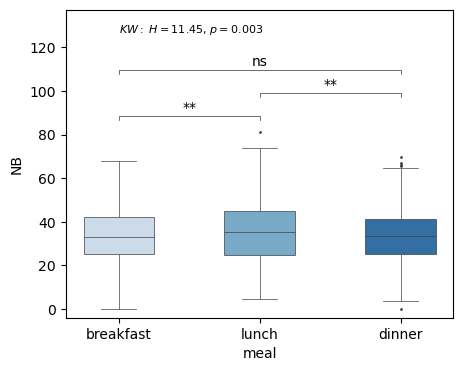

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,4)) 
test_quartile_differences(
    largest_meals, # your dataframe
    'meal', # grouping column (e.g good or bad food group)
    'NB', # target column e.g NB or QI or DI
    extremes=False,
    make_quartile=False,
    palette="Blues",
    verbose=False,
    ax=ax,
)

C:\Users\Sophie\AppData\Local\Temp\ipykernel_19428\363652421.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:5.494e-02 U_stat=4.829e+05
lunch vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:5.551e-01 U_stat=5.157e+05
breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:1.489e-01 U_stat=4.901e+05


<Axes: xlabel='meal', ylabel='QI'>

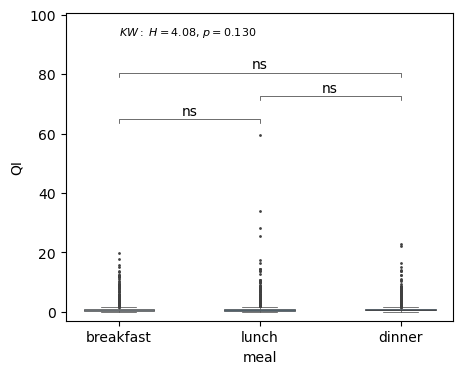

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))  
test_quartile_differences(
    largest_meals, # your dataframe
    'meal', # grouping column (e.g good or bad food group)
    'QI', # target column e.g NB or QI or DI
    extremes=False,
    make_quartile=False,
    palette="Blues",
    verbose=False,
    ax=ax,
)

C:\Users\Sophie\AppData\Local\Temp\ipykernel_19428\363652421.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:3.167e-04 U_stat=5.551e+05
lunch vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:4.968e-02 U_stat=5.337e+05
breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:5.902e-08 U_stat=5.800e+05


<Axes: xlabel='meal', ylabel='DI'>

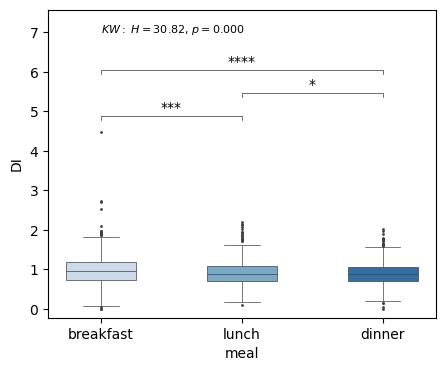

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
test_quartile_differences(
    largest_meals, # your dataframe
    'meal', # grouping column (e.g good or bad food group)
    'DI', # target column e.g NB or QI or DI
    extremes=False,
    make_quartile=False,
    palette="Blues",
    verbose=False,
    ax=ax,
)